In [61]:
# Getting data from aerospace database.
using CSV, DataFrames, Statistics, Random
include("augment.jl")
include("bin_to_leaves.jl")

monomials (generic function with 1 method)

In [62]:
# Optional extra cores
using Distributed
addprocs(2)

2-element Array{Int64,1}:
 6
 7

In [63]:
columns = ["Re", "thick", "M", "C_L"];
X = CSV.read("airfoil_X.csv", copycols=true, header=columns, delim=",");
Y = CSV.read("airfoil_Y.csv", copycols=true, header=["C_D"], delim=",");
X = Matrix(exp.(X)); Y = Matrix(exp.(Y));
Re = Array(range(10000, stop=35000, step=5000));
thick = [100,110,120,130,140,145];
M = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9];
cl = Array(range(0.35, stop=0.70, step=0.05));

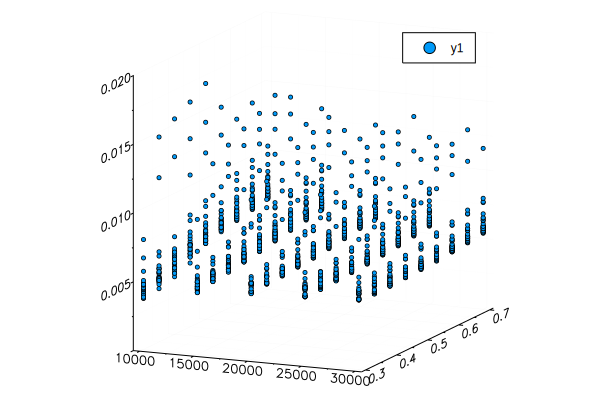

In [4]:
# Plotting some perspectives on the data
using Plots
plt = Plots.plot(X[:,1], X[:,4], Y[:,1], seriestype=:scatter, markersize = 2)
display(plt)

In [5]:
# Splitting data
(train_X, train_y), (test_X, test_y) = IAI.split_data(:regression, seed=1, Matrix(X), Matrix(Y), train_proportion=0.8);
size(train_X)

(1065, 4)

In [6]:
# Let's do fun things with the data.
lnr = IAI.OptimalTreeRegressor(random_seed=1, max_depth=3, cp=0.001, minbucket=0.05, regression_sparsity=:all, 
    regression_lambda = 0.0001)
IAI.fit!(lnr, train_X, train_y)

┌ Warning: This copy of Interpretable AI software is for academic purposes only and not for commercial use.
└ @ IAIBase C:\Users\iai\builds\InterpretableAI\SysImgBuilder\.julia\packages\IAIBase\ymcNn\src\precompile.jl:19
┌ Warning: Interpretable AI license expires soon: 2019-12-31. If you need to renew, please send us the following machine ID:
│ 8bfc038eb024dab42b20ba1f95ee4d62c347e74462a52afce06a13c053edeb6f
└ @ IAIBase C:\Users\iai\builds\InterpretableAI\SysImgBuilder\.julia\packages\IAIBase\ymcNn\src\precompile.jl:29
Training trees with 3 workers...100%|███████████████████| Time: 0:00:18


Fitted OptimalTreeRegressor:
  1) Split: x4 < 0.425
    2) Split: x2 < 0.125
      3) Split: x3 < 0.65
        4) Predict: -0.006539 * x2 - 0.0002794 * x3 + 0.0008303 * x4 + 0.004778, 97 points, error 0.000006801
        5) Predict: -0.0005433 * x2 + 0.007842 * x3 + 0.0008142 * x4 - 0.001949, 60 points, error 0.00002384
      6) Split: x3 < 0.75
        7) Predict: 0.008459 * x2 + 0.000729 * x3 + 0.00413 * x4 + 0.002232, 123 points, error 0.000005174
        8) Predict: 0.04828 * x2 + 0.04726 * x3 + 0.01736 * x4 - 0.04378, 58 points, error 0.00006357
    9) Split: x3 < 0.75
      10) Split: x1 < 17500
        11) Predict: 0.01743 * x2 + 0.001955 * x3 + 0.004999 * x4 + 0.00116, 214 points, error 0.000005061
        12) Predict: 0.01041 * x2 + 0.001463 * x3 + 0.003178 * x4 + 0.002472, 330 points, error 0.000007318
      13) Split: x3 < 0.85
        14) Predict: 0.03718 * x2 + 0.006993 * x4 + 0.00008951, 123 points, error 0.00001178
        15) Predict: 0.1338 * x2 + 0.009278 * x4 - 0.006787, 60 points, error 0.000007107

In [18]:
# Cross-validation of best tree
grids = IAI.GridSearch(lnr, max_depth = [2,3], minbucket=[0.03,0.06,0.09,0.12,0.15])
IAI.fit!(grids, train_X, train_y, test_X, test_y)

Training trees with 3 workers...100%|███████████████████| Time: 0:01:22
Training trees with 3 workers...100%|███████████████████| Time: 0:01:13
Training trees with 3 workers...100%|███████████████████| Time: 0:00:33
Training trees with 3 workers...100%|███████████████████| Time: 0:00:34
Training trees with 3 workers...100%|███████████████████| Time: 0:00:29
Training trees with 3 workers...100%|███████████████████| Time: 0:00:32
Training trees with 3 workers...  1%|█                  |  ETA: 1:35:30

InterruptException: InterruptException:

In [8]:
# Seeing best learner
lnr = IAI.get_learner(grids)

Fitted OptimalTreeRegressor:
  1) Split: x4 < 0.375
    2) Split: x2 < 0.125
      3) Predict: -0.005047 * x2 + 0.00136 * x3 - 0.0006517 * x4 + 0.003939, 124 points, error 0.00002877
      4) Split: x3 < 0.75
        5) Predict: 0.005306 * x2 + 0.0003141 * x3 + 0.003598 * x4 + 0.002775, 97 points, error 0.00000395
        6) Predict: 0.04545 * x2 + 0.04447 * x3 + 0.02987 * x4 - 0.04575, 47 points, error 0.00007042
    7) Split: x3 < 0.75
      8) Split: x1 < 17500
        9) Predict: 0.0181 * x2 + 0.001811 * x3 + 0.005345 * x4 + 0.0008391, 303 points, error 0.00001094
        10) Predict: 0.007988 * x2 + 0.001399 * x3 + 0.002892 * x4 + 0.002895, 490 points, error 0.00001848
      11) Split: x3 < 0.85
        12) Predict: 0.03472 * x2 + 0.006666 * x4 + 0.0004294, 181 points, error 0.00002568
        13) Predict: 0.1437 * x2 + 0.01061 * x4 - 0.008829, 89 points, error 0.00001367

In [17]:
# How about trying sparse hyperplane splits? 
lnr = IAI.OptimalTreeRegressor(random_seed=1, max_depth=3, cp=0.001, minbucket=0.05, 
    hyperplane_config=(sparsity=2,), regression_sparsity=:all, regression_lambda = 0.0001, fast_num_support_restarts =10)
grids = IAI.GridSearch(lnr, max_depth = [2,3], minbucket=[0.03,0.06,0.09,0.12,0.15])
IAI.fit!(grids, train_X, train_y, test_X, test_y)

Training trees with 3 workers...100%|███████████████████| Time: 0:00:53
Training trees with 3 workers...  1%|█                  |  ETA: 0:24:24

InterruptException: InterruptException:

Training trees with 3 workers... 58%|████████████       |  ETA: 0:00:17

In [46]:
# Seeing best learner
lnr = IAI.get_learner(grids)

Fitted OptimalTreeRegressor:
  1) Split: x3 < 0.75
    2) Split: 7.712 * x2 + 1.842 * x4 < 1.699
      3) Split: x1 < 12500
        4) Predict: 0.01744 * x2 - 0.0002284 * x3 + 0.008068 * x4 - 0.0001155, 54 points, error 0.000002376
        5) Predict: -0.01262 * x2 + 0.000248 * x3 - 0.0007989 * x4 + 0.006256, 217 points, error 0.000007852
      6) Split: x1 < 17500
        7) Predict: 0.01633 * x2 + 0.002022 * x3 + 0.005101 * x4 + 0.001249, 269 points, error 0.000005453
        8) Predict: 0.01264 * x2 + 0.001515 * x3 + 0.003605 * x4 + 0.001981, 447 points, error 0.000004632
    9) Split: 8.129 * x2 + 2.929 * x4 < 2.077
      10) Predict: 0.001869 * x2 + 0.03192 * x3 + 0.0004173 * x4 - 0.02255, 56 points, error 0.00004121
      11) Split: x3 < 0.85
        12) Predict: 0.03615 * x2 + 0.007048 * x4 + 0.00009438, 186 points, error 0.00001629
        13) Predict: 0.143 * x2 + 0.011 * x4 - 0.008937, 102 points, error 0.00001657

In [11]:
# MSE errors 
println("Training MSE:", 1 - IAI.score(lnr, train_X, train_y, criterion=:mse))
println("Test MSE:", 1- IAI.score(lnr, test_X, test_y, criterion=:mse))
# MSE error of global posynomial
Re = test_X[:,1]; thickness = test_X[:,2]; M = test_X[:,3]; C_L = test_X[:,4]; C_D = test_y;
CDp = 0.0470226 .* (Re).^-0.388166 .* thickness.^0.782129 .* (M).^-0.339824 .* (C_L).^0.94829 +
    190.63 .* (Re).^-0.218175 .* thickness.^3.94137 .* (M).^19.2346 .* (C_L).^1.14997 +
    1.62158 .* (Re).^-0.549562 .* thickness.^1.2895 .* (M).^3.03057 .* (C_L).^1.77464 +
    2.91642e-12 .* (Re).^1.18062 .* thickness.^-1.75547 .* (M).^0.105431 .*(C_L).^-1.4407;
CDp = CDp.^(1/1.64722);
MSEposy = mean((C_D-CDp).^2);
println("Test MSE of global posynomial: ", MSEposy)

Training MSE:0.03130672733667528
Test MSE:0.03141658958780125
Test MSE of global posynomial: 1.7175114191885618e-7


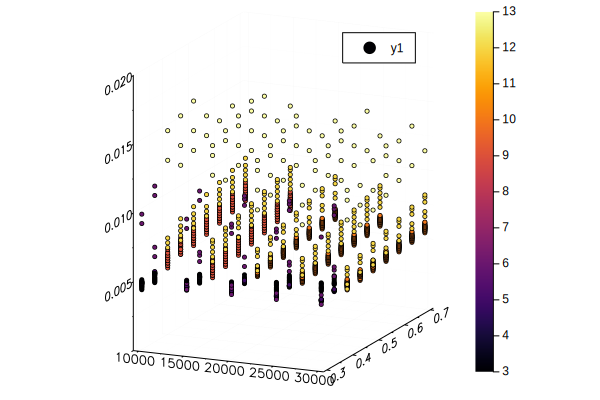

In [12]:
# Plotting some perspectives on the data, with predictions
using Plots
leaf_index, all_leaves = bin_to_leaves(lnr, X);
predictions = IAI.predict(lnr, X)
# plt = Plots.plot(X[:,1], X[:,4], Y[:,1], seriestype=:scatter, markersize = 2)
plt = Plots.plot(X[:,1], X[:,4], predictions, zcolor=leaf_index, seriestype=:scatter, markersize = 2)
display(plt)

In [15]:
# Let's try convex regression... this is the MIO approach for HW2
include("convexRegress.jl");
thetas, ksis = convexRegress(Y, X,10000,1/1000, 1e-2)
println("MSE of convex regression: ", mean((thetas-Y).^2))

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 2662 rows, 6655 columns and 8394 nonzeros
Model has 6651 quadratic objective terms
Coefficient statistics:
  Matrix range     [5e-03, 2e+04]
  Objective range  [4e-03, 2e-02]
  QObjective range [1e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 2 rows and 3591 columns
Presolve time: 0.00s
Presolved: 2660 rows, 3064 columns, 8385 nonzeros
Presolved model has 3064 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 3064
 AA' NZ     : 6.646e+03
 Factor NZ  : 3.585e+04 (roughly 3 MBytes of memory)
 Factor Ops : 5.717e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  0.00e+00 1.71e-02  1.00e+06     0s
   1   5.16141704e+07 -5.16141691e+07  2.85e+0

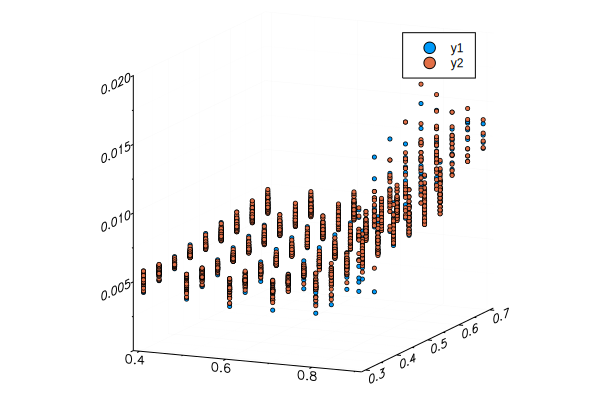

In [16]:
# Plotting results
plt = Plots.plot(X[:,3], X[:,4], Y[:,1], seriestype=:scatter, markersize = 2)
plt = Plots.plot!(X[:,3], X[:,4], thetas, seriestype=:scatter, markersize = 2)
display(plt)

In [70]:
# Nonlinear augmentations of the data
include("augment.jl")
fn_arr, fn_names = quad_fns(X);
X = augment(X, fn_arr, fn_names);
X, means, vars = normalize(X);
# # Splitting data
(train_X, train_y), (test_X, test_y) = IAI.split_data(:regression, seed=1, Matrix(X), Matrix(Y), train_proportion=0.8);
size(train_X)

(1065, 8)

In [72]:
# Learn non-linearities
lnr = IAI.OptimalTreeRegressor(random_seed=1, cp=0.001, minbucket=0.05, regression_sparsity=:all, 
    split_features=[1,2,3,4], regression_weighted_betas=true)
grids = IAI.GridSearch(lnr, max_depth = [3], minbucket=[0.03], regression_lambda=[0.001,0.000005])
IAI.fit!(grids, train_X, train_y, test_X, test_y)

Training trees with 7 workers...  1%|█                  |  ETA: 0:02:56┌ Warning: Numeric instability detected: objective value after iteration did
│ not match the value that was expected so this change was rejected.
│ 
│ Possible causes include:
│ - using linear regression in the leaves with a small `minbucket`
│ - using `:tweedie` criterion with a large number of samples
│ 
│ If none of these apply, please let us know so we can investigate.
└ @ OptimalTrees C:\Users\iai\builds\InterpretableAI\SysImgBuilder\.julia\packages\OptimalTrees\D3J3L\src\localsearch\greedy.jl:77
┌ Warning: Numeric instability detected: objective value after iteration did
│ not match the value that was expected so this change was rejected.
│ 
│ Possible causes include:
│ - using linear regression in the leaves with a small `minbucket`
│ - using `:tweedie` criterion with a large number of samples
│ 
│ If none of these apply, please let us know so we can investigate.
└ @ OptimalTrees C:\Users\iai\builds\Interpret

All Grid Results:

│ Row │ minbucket │ regression_lambda │ max_depth │ cp        │ train_score │
│     │ Float64   │ Float64           │ Int64     │ Float64   │ Float64     │
├─────┼───────────┼───────────────────┼───────────┼───────────┼─────────────┤
│ 1   │ 0.03      │ 5.0e-6            │ 3         │ 0.5       │ 0.770283    │
│ 2   │ 0.03      │ 0.001             │ 3         │ 0.0838374 │ 0.934537    │

│ Row │ valid_score │ rank_valid_score │
│     │ Float64     │ Int64            │
├─────┼─────────────┼──────────────────┤
│ 1   │ 0.793536    │ 2                │
│ 2   │ 0.925438    │ 1                │

Best Params:
  minbucket => 0.03
  regression_lambda => 0.001
  cp => 0.0838373871995208
  max_depth => 3

Best Model - Fitted OptimalTreeRegressor:
  1) Predict: -0.0002841 * x1 - 0.0002355 * x2 - 0.007823 * x3 + 0.001123 * x4 + 0.00007695 * x5 + 0.0005418 * x6 + 0.009144 * x7 - 0.0005762 * x8 + 0.006449, 1331 points, error 0.001239

In [73]:
lnr = IAI.get_learner(grids)

Fitted OptimalTreeRegressor:
  1) Predict: -0.0002841 * x1 - 0.0002355 * x2 - 0.007823 * x3 + 0.001123 * x4 + 0.00007695 * x5 + 0.0005418 * x6 + 0.009144 * x7 - 0.0005762 * x8 + 0.006449, 1331 points, error 0.001239

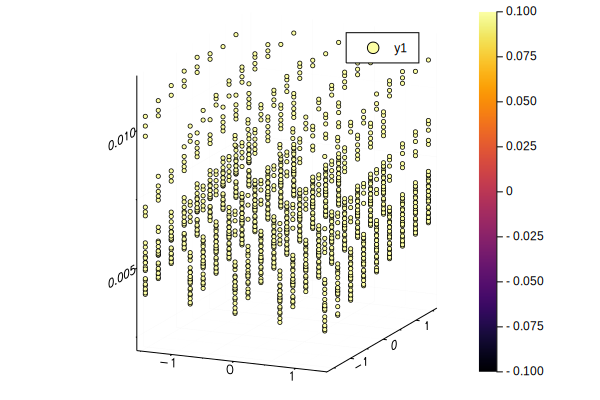

In [74]:
# Plotting some perspectives on the data, with predictions
using Plots
leaf_index, all_leaves = bin_to_leaves(lnr, X);
predictions = IAI.predict(lnr, X)
plt = Plots.plot(X[:,1], X[:,4], Y[:,1], seriestype=:scatter, markersize = 2)
plt = Plots.plot(X[:,1], X[:,4], predictions, zcolor=leaf_index, seriestype=:scatter, markersize = 2)
display(plt)

In [80]:
# MSE errors 
println("MSE:", mean(((predictions-Y)./Y).^2))

MSE:0.01979520053774691


0.01979520053774691